## Advertising campaign
An advertising campaign is a series of advertisement messages that share a single idea. Advertising campaigns utilize diverse media channels over a particular time frame and target identified audiences.

*Una CA decide come suddividere il budget in maniera tale da promuovere il prodotto su diversi canali di advertising nel modo migliore. Partendo da un singolo prodotto, vogliamo pubblicizzarlo su diversi canali tramite ads. Definito un profilo target che vogliamo raggiugere su ogni canale, dobbiamo scegliere un bid e un daily budget. An advertising campaign è una collezione di sotto campagne alle quali bisogna allocare un tot di daily budget.*

An advertising campaign has a fixed budget which is then splitted over several channels in order to promote a product/service. In order to do it, we use ads that can be different depending on each channel. Once we profile our target, which drives the subcampaign, we need to fix a bid and a daily budget. 

Therefore, an advertising campaign is a collection of subcampaigns to which it needs to allocate part of the budget

*La nostra campagna è formata da diverse sottocampagne principalmente suddivise nei diversi channel e per ognuno, andando a definire il target e il periodo temporale. 
Per semplicità, calcoliamo il bid direttamente nel codice.*

Our campaign collects several subcampaigns mainly splitted in channels and then defining the target profile and the time we want to run the ads. 

## Optimization Problem
Si presenta dunque il problema di allocare in maniera ottimale il budget totale della campagna nelle diverse sotto campagne. 
**assunzioni**

Hence there is the problem of allocating the total campaign budget overall the different subcampaigns.

Our **assumptions** are:

1. The performance of every subcampaign is independent of the performance of the other subcampaigns
2. The values of bid and daily budget are finite

## Formal Model

The model definition is:

* $N$ number of sub campaigns composing the advertising campaing $C$

* $C = \left\{C_{1}, ..., C_{N}\right\}$ advertising campaigns

* $T$ time horizon 

* $t \in T$ time 

* $X_{j}$ bid for subcapaign *j*

* $Y_{j}$ daily budget for subcampaign *j*

* $B$ spending plan where $B_{j,t}$ is the pair $\left[\underline{y}_{j,t}, \bar{y}_{j,t}\right]$ that are respectively the minimum and maximum cumulative daily budget for campaign $j \in N$ for the day $t \in T$

* $v_{j}$ value per click for subcampaign $j \in N$

* $n_{j}(x_{j}, y_{j})$ number of clicks for subcampaign $j \in N$ given values of bid $x_{j} \in X_{j}$ and budget $y_{j} \in Y_{j}$



  $C_{j}: X_{j} \times Y_{j}$ the advertising campaign $j \in N, \forall j \in N$, where $C_{j}(x_{j}, y_{j}) = v_{j}n_{j}(x_{j}, y_{j})$
  
  $M_{j}:$ max number of clicks for each budget $y_{j} \in Y_{j}$ for each subcampaing $j \in N \cup \varnothing$, where the first row of the matrix ($j = 0$) correspond to the initialization of the algorithm with all values set to $0$.
  
  Objective Function:

  * $\max_{x_{j,t}, y_{j,t}}{\sum_{j \in N}{v_{j}n_{j}(x_{j,t}, y_{j,t})}}$ 
  
  such that: 
  
  * $\sum_{j \in N}{y_{j,t}} \leq \bar{y}_{t}, \forall t \in T$
  
  * $\underline{x}_{j,t} \leq x_{j,t} \leq \bar{x}_{j,t}, \forall j \in N, \forall t \in T$
  
  * $\underline{y}_{j,y} \leq y_{j,t} \leq \bar{y}_{j,t}, \forall j \in N, \forall t \in T$

## Knapsack

In [1]:
from experiment_2 import *

In [2]:
max_budget = 10 # maximal amount of budget
n_arms = 11 # number of equispaced values in which the budget is subdivided, starting from 0
advertising_env_id = 0 # id of the campaign to use

exp = Experiment_2(max_budget, n_arms, advertising_env_id)

Let's run the clairvoyant algorithm and see how the knapsack algorithm performs on the real environment.

In [3]:
exp.run_clairvoyant()

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,Budget
C0,0.000,110.621,151.316,166.287,171.795,173.821,174.566,174.840,174.941,174.978,174.992,4
C1,0.000,51.924,71.026,78.053,80.638,81.589,81.939,82.068,82.115,82.133,82.139,3
C2,0.000,45.151,61.762,67.872,70.120,70.947,71.252,71.363,71.405,71.420,71.425,3


## Gaussian Process
If we discrete the curves and we estimate the values of each points, the number of samples required is too large. We assume that there is correlation among the points so we use Gaussian processes to learn these functions.
A Gaussian process provides a probability distribution over the predictions that's crucial to assure the convergency of bandit algorithms. 


## Combinatorial GP Bandit Algorithm
We put together combinatorial bandit with gaussian processes because arms are correlated and the reward of an arm provides information on the reward of the arms close to it. 

 * At every time $t$ for every arm $a$:
  
      $\tilde{\theta_{a}} \leftarrow Sample(\mathbb P(\mu_{a}=\theta_{a}))$
  
      $a_{t} \leftarrow \DeclareMathOperator*{\argmax}{arg\,max}
  \argmax_a \left\{ \tilde{\theta_{a}} \right\} $

      $n_{j}(y) \leftarrow Sampling(\mathbf{a})$
      

 * $\left\{\hat{y}_{j,t}\right\}_{j \in N} \leftarrow Optimize(\left\{(v_{j}, n_{j}(y), Y_{j}\right\}_{j \in N}, \bar{y}_{t})$

Each subcampaign is modeled by a gaussian process with the constraint that at most a daily budget value can be chose. 
Since it's combinatorial, we can pull different sets of arms in order to satisfy our knapsack constraint that's our maximum budget $B$. 

## Experiment

We ran an experiment with fixed values in a stationary environment. We used:


* **sample_factor:**  ---------------------------------
* **horizon:** ---------------------------------



In [6]:
sample_factor = 8
horizon= 14 * sample_factor

Let's run an experiment and see how the Guassian Procceses performs on each subcampaign.

Performing experiment:  1


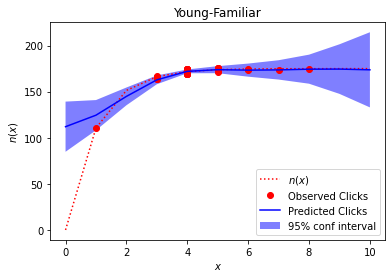

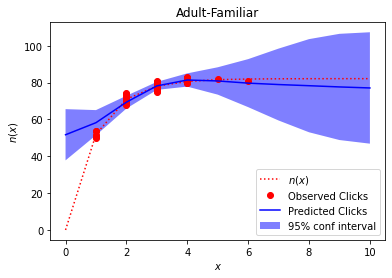

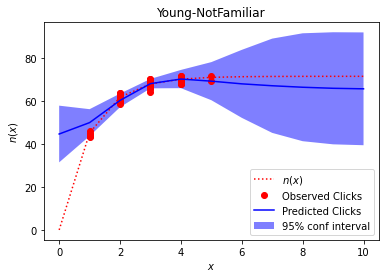

In [7]:
exp.run(1, horizon, GP_graphs=True)

To get a more precise result we'll performs multiple experiments and average the estimated values.

In [8]:
n_experiments= 10 # number of experiment to perform

exp.run(n_experiments, horizon)

Performing experiment:  1
Performing experiment:  2
Performing experiment:  3
Performing experiment:  4
Performing experiment:  5
Performing experiment:  6
Performing experiment:  7
Performing experiment:  8
Performing experiment:  9
Performing experiment:  10


## Results

With such configuration, we ran the experiment ten times overall the first campaign hence targetting young people with family. Each experiment runs for a week (i think -----------).
Here are the results respectively for the regret and rewards

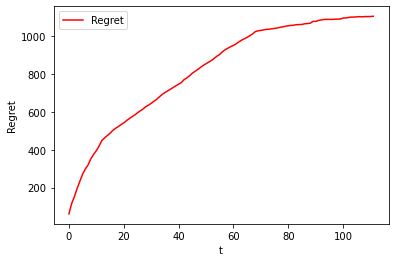

Clairvoyant value: 317.72032055226384


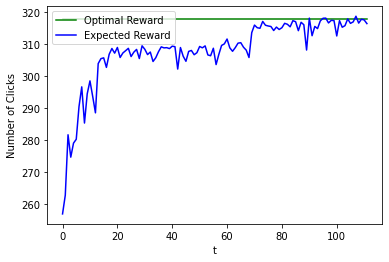

In [9]:
exp.plot_regret()
print('Clairvoyant value: {}'.format(exp.opt_super_arm_reward)) #clairvoyant value
exp.plot_experiment()

## Non-Stationary Experiment

We ran a non-stationary experiment with the same configuration to easily compare with the previous results. 
In order to do so, we took into account the sliding windows phenomena in the environment. To do so, we use the SW-Thompson sampling.

### SW-Thompson Sampling


1. At every time $t$ for every arm $a$:
  
      $\tilde{\theta_{a}} \leftarrow Sample(\mathbb P(\mu_{a}=\theta_{a}))$
  
      $a_{t} \leftarrow \DeclareMathOperator*{\argmax}{arg\,max}
  \argmax_a \left\{ \tilde{\theta_{a}} \right\} $

      
2. Update the Beta distribution of arm a t as:

    * if t ≤ $τ$ : ($α$ a t , $β$ a t ) $\leftarrow$ ($α$ a t , $β$ a t ) + ($x$ a t ,t ,1 − $x$ a t ,t )
    
    * if $τ$ < t : ($α$ a t , $β$ a t ) $\leftarrow$ max { (1,1), ($α$ a t , $β$ a t ) + ($x$ a t ,t ,1 − $x$ a t ,t ) − ($x$ a t−$τ$ ,t−$τ$ ,1 − $x$ a t−$τ$ ,t−$τ$ ) }

In [10]:
from experiment_3 import *

In [11]:
ns_exp = Experiment_3(max_budget, n_arms, sample_factor, advertising_env_id, estimate_hyperparam= True)
ns_exp.run(n_experiments, horizon)

Performing experiment:  1
Performing experiment:  2
Performing experiment:  3
Performing experiment:  4
Performing experiment:  5
Performing experiment:  6
Performing experiment:  7
Performing experiment:  8
Performing experiment:  9
Performing experiment:  10


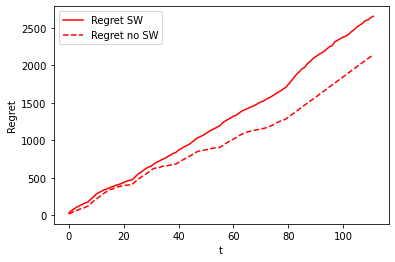

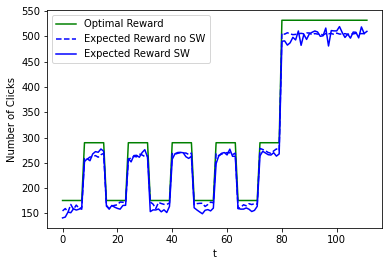

In [12]:
ns_exp.plot_regret()
ns_exp.plot_experiment()